In [1]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta

import tensorflow as tf

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)
from utils.helper import fn_plot_tf_hist

In [2]:
PATIENCE = 20
LR_FACTOR = .2
LR_PATIENCE = 5


In [3]:
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = os.path.join('..', 'model')


EPOCHS = 30
ALPHA = .001
TEST_SIZE = .2  


BATCH_SIZE = 32 # default batch size fot tf
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.RandomState(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) ######

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

## define data


In [5]:
fileName = 'weatherHistory.csv'

data_df = pd.read_csv(os.path.join(inpDir, fileName))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


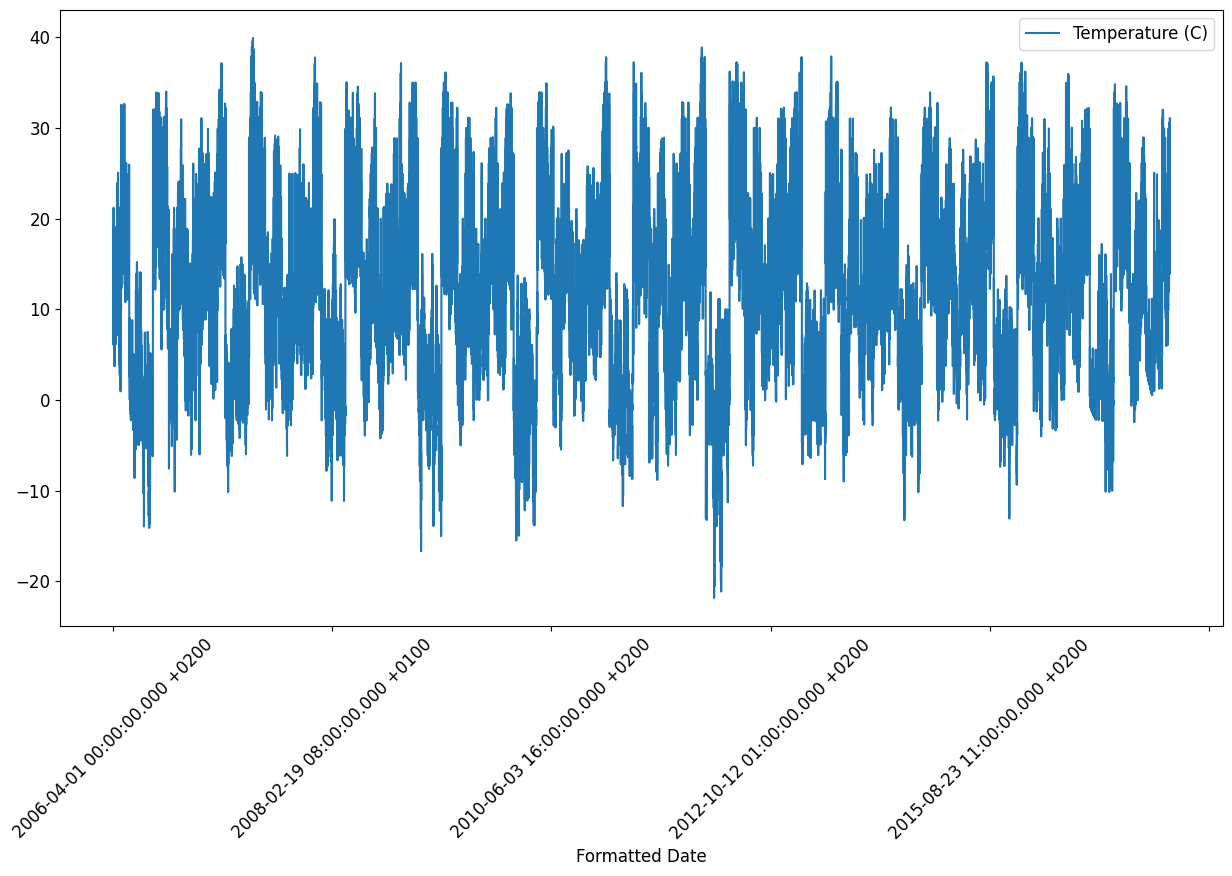

In [6]:
fig, ax = plt.subplots()
data_df.plot(x = 'Formatted Date', y = 'Temperature (C)', ax = ax)
plt.xticks(rotation = 45);

In [7]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)

In [8]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


In [9]:
tmp_df= data_df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)','datetime']]
tmp_df= tmp_df.sort_values('datetime', axis =0, ascending = True)
tmp_df= tmp_df.reset_index(drop=True)
tmp_df= tmp_df.rename({'Temperature (C)': 'temp', 'Humidity': 'hum', 'Wind Speed (km/h)': 'Wind', 'Visibility (km)':'vis'}, axis=1)
tmp_df.head()

,temp,hum,Wind,vis,datetime
0,0.577778,0.89,17.1143,9.9820,2005-12-31 23:00:00+00:00
1,1.161111,0.85,16.6152,9.9015,2006-01-01 00:00:00+00:00
2,1.666667,0.82,20.2538,9.9015,2006-01-01 01:00:00+00:00
3,1.711111,0.82,14.4900,9.9015,2006-01-01 02:00:00+00:00
4,1.183333,0.86,13.9426,9.9015,2006-01-01 03:00:00+00:00


In [10]:
print(tmp_df.shape)
tmp_df.shape[0]/24

(96453, 5)


4018.875

In [11]:
time_step = 24
tmp_df.shape[0]/time_step
# 4018*24 = 96432
y_idx= np.arange(time_step, tmp_df.shape[0], time_step)
y_df = tmp_df.iloc[y_idx][['datetime','temp']]
y_df.head() # it is our target

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [12]:
tmp_df = tmp_df.iloc[range(len(y_df)* time_step)]
tmp_df.shape

(96432, 5)

In [13]:
# time_step = 24
# temp_df.shape[0]/time_step
# # 4018*24 = 96432
# y_idx= np.arange(time_step, temp_df.shape[0], time_step)
# y_df=temp_df.iloc[y_idx]
# y_df # it is our target

In [14]:
# reshape to match number of rows in y_df
X_temp = np.reshape(tmp_df['temp'].values, (y_df.shape[0], time_step))
X_hum = np.reshape(tmp_df['hum'].values, (y_df.shape[0], time_step))
X_wind = np.reshape(tmp_df['Wind'].values, (y_df.shape[0], time_step))
X_vis = np.reshape(tmp_df['vis'].values, (y_df.shape[0], time_step))
X_temp.shape

(4018, 24)

In [15]:
# remove last column
X_temp = X_temp[:, :23]
X_hum = X_hum[:,:23]
X_wind= X_wind[:, :23]
X_vis= X_vis[:, :23]

In [30]:
X_data = np.stack((X_temp,
                   X_hum,
                   X_vis,
                   X_wind))
X_data.shape

(4, 4018, 23)

In [32]:
X_data = np.stack((X_temp,
                   X_hum,
                   X_vis,
                   X_wind)) # horizontal stacking
# needs to be reshaped 
# shape(no of smaple , no of timestamp , NO OF FEATURE) is( NEED FOR RNN COMULSORIY)
X_data=np.reshape(X_data, (X_temp.shape[0],X_temp.shape[1],4))
X_data.shape

(4018, 23, 4)

In [34]:
split = int(y_df.shape[0]* (1- TEST_SIZE))
split

3214

In [36]:
X_train = X_data[:split]
X_test = X_data[split:]
y_train= y_df['temp'].values[:split]
y_test= y_df['temp'].values[split:]
X_train.shape ,X_test.shape, y_train.shape, y_test.shape

((3214, 23, 4), (804, 23, 4), (3214,), (804,))

In [39]:
h_units= 256 # hidden_units = no of nodes/neurons in the hidden layer
input_shape =(time_step - 1, X_train.shape[2]) # 23, 1
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape= input_shape))
model.add(tf.keras.layers.SimpleRNN(units= h_units,
                                    kernel_initializer = initializer,
                                    activation = 'tanh'))
          # units = Positive integer, dimensionality of the output space.
          # tanh is default activation
model.add(tf.keras.layers.Dense(1,
                                kernel_initializer = initializer,
                                activation = 'linear'))

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        66,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
EPOCHS

30

In [45]:
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'RMS', dtype = None)])


history = model.fit( x = X_train, y = y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
          validation_data = [X_test, y_test],
          verbose = 1)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - RMS: 8.5077 - loss: 72.4404 - val_RMS: 7.3173 - val_loss: 53.5429
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - RMS: 8.1991 - loss: 67.2473 - val_RMS: 7.3574 - val_loss: 54.1318
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - RMS: 8.0479 - loss: 64.7848 - val_RMS: 7.2865 - val_loss: 53.0933
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - RMS: 7.9759 - loss: 63.6283 - val_RMS: 7.2807 - val_loss: 53.0092
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - RMS: 7.9293 - loss: 62.8880 - val_RMS: 7.4424 - val_loss: 55.3890
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - RMS: 7.8829 - loss: 62.1547 - val_RMS: 7.4177 - val_loss: 55.0224
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - RMS: 7.8529 - loss: 61.6849 - val_RMS: 7.4713 - val_loss: 55.8199
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - RMS: 7.8966 - loss: 62.3775 - val_RMS: 7.4331 - val_loss: 55.2515
Epoch 9/30
101/101 ━━━━━━━━━━━━━

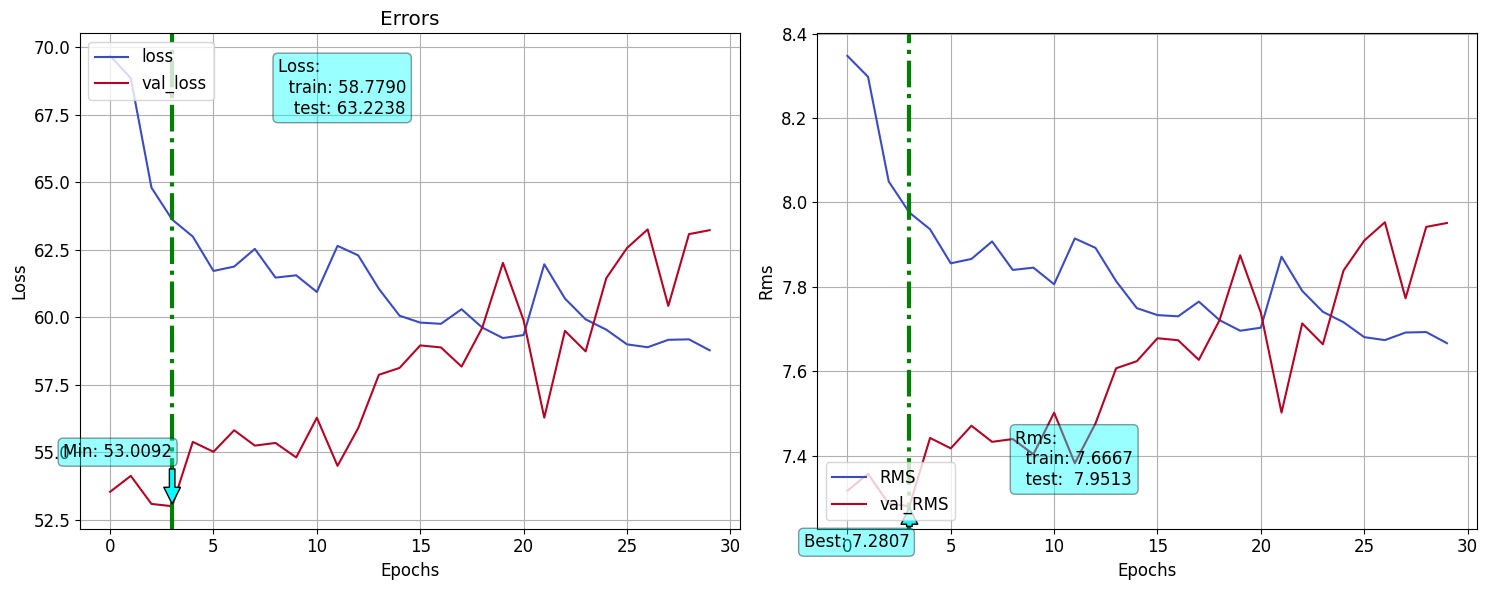

In [46]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [47]:
y_tr_pred = model.predict(X_train)
y_ts_pred = model.predict(X_test)
y_pred = np.append(y_tr_pred, y_ts_pred)

res_df = y_df.copy()
res_df['pred'] = y_pred
res_df.head()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,9.352265
48,2006-01-02 23:00:00+00:00,1.694444,9.280871
72,2006-01-03 23:00:00+00:00,2.200000,8.627093
96,2006-01-04 23:00:00+00:00,1.666667,9.505672
120,2006-01-05 23:00:00+00:00,1.805556,8.591414


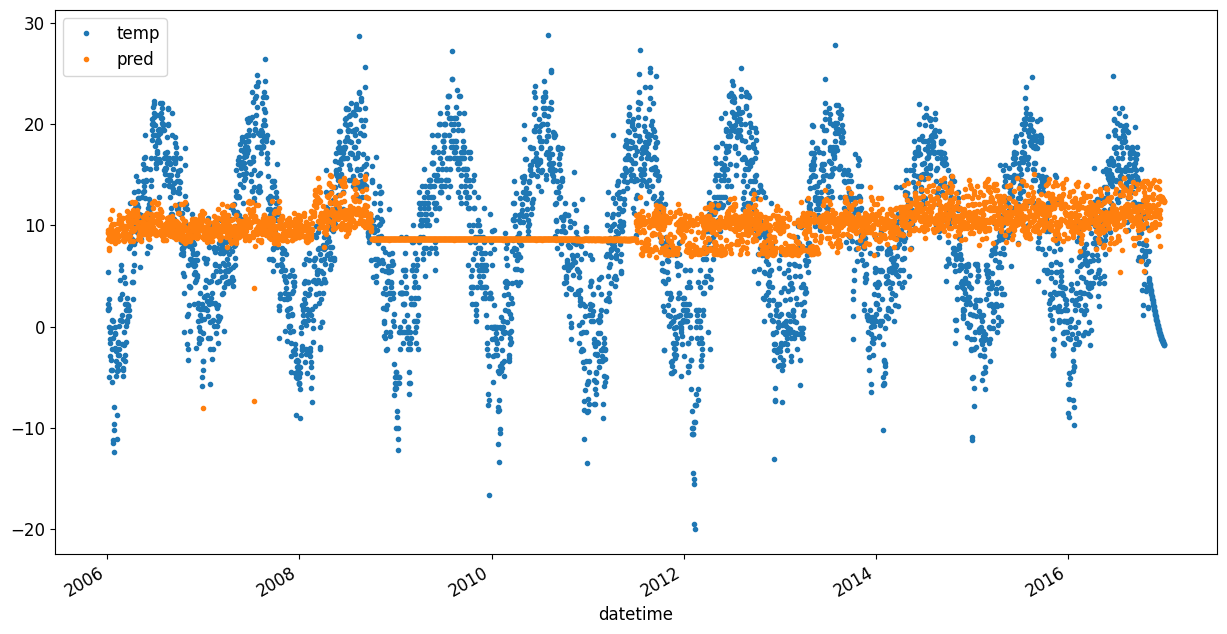

In [48]:
res_df.plot(x = 'datetime', y = ['temp', 'pred'], style = '.');